# Kaggle Titanic

This notebook contains data cleaning, model building, and model training & optimization. I use Random Trees classifier to predict survivability on the Titanic. After submission, the accuracy on Kaggle was 0.78708 which is in the top 13th percentile of scores as of 12/30/21.

## Data Cleaning & Feature Engineering

In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv('train.csv')

# Look at feature spread and null values
print(df.head())
print(df.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Pa

In [2]:
def prepare_data(df):
    # Categorize passengers by whether or not they have a cabin
    df["Cabin"] = df["Cabin"].apply(lambda x: 1 if not pd.isnull(x) else 0)

    # Fill missing "Age" with means
    df["Age"].fillna(df["Age"].mean(), inplace=True)

    # Replace Sex column with numerical values
    df['Sex']= df['Sex'].replace({"male": 0, "female": 1})
    
    # One-hot encode our Embarked and Pclass variables 
    categorical_features = ["Embarked", "Pclass"]
    df = pd.get_dummies(df, columns=categorical_features)

    return df
 

df = prepare_data(df)

print(df.isnull().sum())

PassengerId    0
Survived       0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Pclass_1       0
Pclass_2       0
Pclass_3       0
dtype: int64


## Split into Training and Testing Datasets



In [3]:
# Split the dataset in an 40/60 train/test ratio.
# The dataset is relatively small so this will allow us to keep a 
train, test = train_test_split(df, test_size=0.6, random_state=2, shuffle=True)

print(df.head())
print("train shape:", train.shape)
print("test shape:", test.shape)

   PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

   Sex   Age  SibSp  Parch            Ticket     Fare  Cabin  Embarked_C  \
0    0  22.0      1      0         A/5 21171   7.2500      0           0   
1    1  38.0      1      0          PC 17599  71.2833      1           1   
2    1  26.0      0      0  STON/O2. 3101282   7.9250      0           0   
3    1  35.0      1      0            113803  53.1000      1           0   
4    0  35.0      0      0            373450   8.0500      0           0   

   Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  
0         

## Building Model - Random Forest Classifier

In [5]:
features = [c for c in df.columns if c not in ["Survived", "Ticket", "Name", "PassengerId"]]
print(features)

print(f"Number of Features: {len(features)}")

def fit_test_model(model):
    '''
    Tests a model against train and test sets after training
    '''  
    global features

    # Train the model
    model.fit(train[features], train.Survived)

    # Assess performance using accuracy scores
    # -- Train
    predictions = model.predict(train[features])
    train_accuracy = balanced_accuracy_score(train.Survived, predictions)

    # -- Test
    predictions = model.predict(test[features])
    test_accuracy = balanced_accuracy_score(test.Survived, predictions)

    return train_accuracy, test_accuracy

['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
Number of Features: 12


### Find the optimal number of trees.

   Number of Trees      Test     Train
0             10.0  0.763193  0.963954
1             20.0  0.774464  0.964870
2             30.0  0.778492  0.983118
3             40.0  0.786733  0.983118
4             50.0  0.782779  0.983118
5             60.0  0.779084  0.986768
6             70.0  0.788840  0.986768
7             80.0  0.784885  0.986768
8             90.0  0.784294  0.986768
9            100.0  0.787324  0.986768


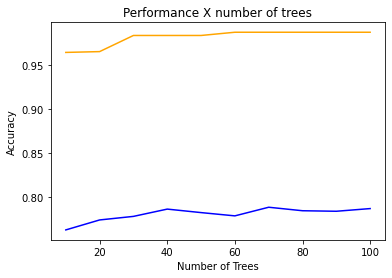

In [6]:
n_estimators = [x for x in range(10, 101, 10)]

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for n_estimator in n_estimators:
    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=n_estimator, 
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

n_estimator_accuracy = pd.DataFrame(
                    np.column_stack([n_estimators, test_accuracies, train_accuracies]), 
                    columns=['Number of Trees', 'Test', 'Train'])
print(n_estimator_accuracy)

# Plot results
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title("Performance X number of trees")
plt.plot(n_estimators, test_accuracies, color="blue")
plt.plot(n_estimators, train_accuracies, color="orange")
plt.show()

Using n_estimators=40 results in the highest test accuracy before overfitting occurs.

### Altering the minimum number of samples for split parameter

    Min Samples Split      Test     Train
0                 2.0  0.786733  0.983118
1                 3.0  0.781005  0.963954
2                 4.0  0.798004  0.958021
3                 5.0  0.785735  0.933840
4                 6.0  0.789431  0.929274
5                 7.0  0.794900  0.919691
6                 8.0  0.801293  0.910109
7                 9.0  0.792461  0.902810
8                10.0  0.804324  0.882278
9                20.0  0.778936  0.816568
10               50.0  0.787842  0.827517


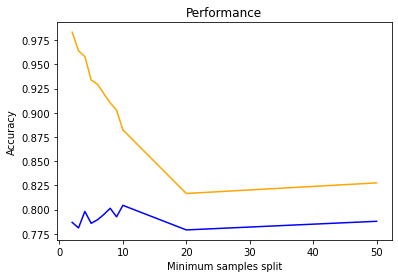

In [8]:
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for min_samples in min_samples_split:
    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=40,
                                min_samples_split=min_samples,
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


min_samples_accuracy = pd.DataFrame(
                    np.column_stack([min_samples_split, test_accuracies, train_accuracies]), 
                    columns=['Min Samples Split', 'Test', 'Train'])
print(min_samples_accuracy)

# Plot results
plt.xlabel('Minimum samples split')
plt.ylabel('Accuracy')
plt.title("Performance")
plt.plot(min_samples_split, test_accuracies, color="blue")
plt.plot(min_samples_split, train_accuracies, color="orange")
plt.show()

Using  `min_samples_split=10`  gives us the best result for test accuracy, and higher values decrease the accuracy.

### Altering the model depth

    Max Depths      Test     Train
0          1.0  0.651293  0.672899
1          2.0  0.742276  0.749525
2          3.0  0.786179  0.810652
3          4.0  0.782557  0.827984
4          5.0  0.783481  0.831184
5          6.0  0.788433  0.872246
6          7.0  0.788766  0.904643
7          8.0  0.793644  0.934757
8          9.0  0.794900  0.953005
9         10.0  0.787324  0.961221
10        11.0  0.781855  0.968520
11        12.0  0.782188  0.969886
12        13.0  0.767554  0.979469
13        14.0  0.779157  0.983118
14        15.0  0.783703  0.983118
15        16.0  0.790687  0.983118
16        17.0  0.786733  0.983118
17        18.0  0.786733  0.983118
18        19.0  0.786733  0.983118
19        20.0  0.786733  0.983118


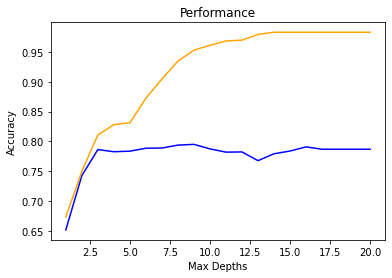

In [9]:
max_depths = [x for x in range(1, 21)]

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=40,
                                max_depth=max_depth,
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

max_depths_accuracy = pd.DataFrame(
                    np.column_stack([max_depths, test_accuracies, train_accuracies]), 
                    columns=['Max Depths', 'Test', 'Train'])
print(max_depths_accuracy)

# Plot results
plt.xlabel('Max Depths')
plt.ylabel('Accuracy')
plt.title("Performance")
plt.plot(max_depths, test_accuracies, color="blue")
plt.plot(max_depths, train_accuracies, color="orange")
plt.show()

The plot and max depths table shows that the model benefits from a higher max depth up to 9. Increasing depth after 9 harm test performance, because it limits the model too much for it to generalize.

### Find the optimal number of features to use.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    Number of Features      Test     Train
0                  1.0  0.787435  0.918853
1                  2.0  0.787446  0.920797
2                  3.0  0.787137  0.923635
3                  4.0  0.785043  0.929622
4                  5.0  0.787520  0.929103
5                  6.0  0.784333  0.932661
6                  7.0  0.784703  0.934067
7                  8.0  0.782684  0.937800
8                  9.0  0.781340  0.938247
9                 10.0  0.781657  0.941496
10                11.0  0.779905  0.941141
11                12.0  0.778304  0.942665


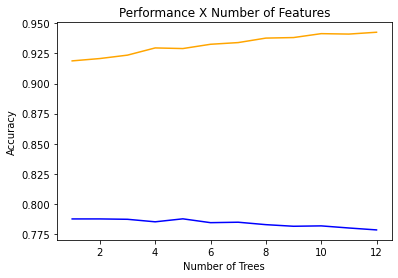

In [11]:
# There are 13 features so we want to find the optimal
# number to use.
n_features = [x for x in range(1, 13)]
print(n_features)

# Train our models and report their performance
all_train_accuracies = list()
all_test_accuracies = list()

# Use different values for random_state to find
# average accuracies
for random_n in list(range(50)):
    test_accuracies = []
    train_accuracies = []

    for n_feature in n_features:
        # Prepare the model 
        rf = RandomForestClassifier(n_estimators=20,
                                max_depth=16,
                                max_features=n_feature,
                                min_samples_split=5,
                                random_state=random_n, 
                                verbose=False)
        
        # Train and test the result
        train_accuracy, test_accuracy = fit_test_model(rf)

        # Save the results
        test_accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)

    all_test_accuracies.append(test_accuracies)
    all_train_accuracies.append(train_accuracies)

test_array = np.array(all_test_accuracies)
avg_test_accuracies = np.average(test_array, axis=0)

train_array = np.array(all_train_accuracies)
avg_train_accuracies = np.average(train_array, axis=0)


# Present accuracy results
n_features_accuracy = pd.DataFrame(
                    np.column_stack([n_features, avg_test_accuracies, avg_train_accuracies]), 
                    columns=['Number of Features', 'Test', 'Train'])
print(n_features_accuracy)

# Plot results
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title("Performance X Number of Features")
plt.plot(n_features, avg_test_accuracies, color="blue")
plt.plot(n_features, avg_train_accuracies, color="orange")
plt.show()

Attempting to find the optimal number of max features is difficult because accuracies change with different random states. However, taking an average of accuracies from different random states can help us. In this case, the optimal number of max features is 5.

### Find the optimal test size

In [17]:
test_accuracies = []
test_sizes = list(np.arange(0.2, 0.8, 0.02))

for size in test_sizes:
        train, test = train_test_split(df, test_size=size, random_state=2, shuffle=True)

        # Prepare the model 
        rf = RandomForestClassifier(n_estimators=40,
                                max_depth=9,
                                max_features=5,
                                min_samples_split=10,
                                random_state=1, 
                                verbose=False)

        # Train and test the result
        train_accuracy, test_accuracy = fit_test_model(rf)
        
        test_accuracies.append(test_accuracy)

test_size_accuracy = pd.DataFrame({"size": test_sizes, "accuracy": test_accuracies})
print(test_size_accuracy)


    size  accuracy
0   0.20  0.761456
1   0.22  0.751467
2   0.24  0.760989
3   0.26  0.780907
4   0.28  0.763061
5   0.30  0.763426
6   0.32  0.749189
7   0.34  0.770257
8   0.36  0.783744
9   0.38  0.771033
10  0.40  0.763804
11  0.42  0.792677
12  0.44  0.770136
13  0.46  0.789867
14  0.48  0.794911
15  0.50  0.789184
16  0.52  0.803951
17  0.54  0.788009
18  0.56  0.778863
19  0.58  0.786909
20  0.60  0.784553
21  0.62  0.768354
22  0.64  0.776048
23  0.66  0.779815
24  0.68  0.760580
25  0.70  0.769792
26  0.72  0.768698
27  0.74  0.775091
28  0.76  0.775791
29  0.78  0.784103
30  0.80  0.795671


The test accuracy is the highest when the test size is 0.52.

## Optimizing the Model

In [18]:
train, test = train_test_split(df, test_size=0.52, random_state=2, shuffle=True)

# Prepare the model with the optimal n_estimators, max_depth,
# max_features, and min_samples_split.
rf = RandomForestClassifier(n_estimators=40,
                        max_depth=9,
                        max_features=5,
                        min_samples_split=10,
                        random_state=1, 
                        verbose=False)

# Train and test the result
train_accuracy, test_accuracy = fit_test_model(rf)

# Print the results
data = {"Model": ["Final random forest"],
        "Train sensitivity": [train_accuracy],
        "Test sensitivity": [test_accuracy]
        }

results = pd.DataFrame(data, columns = ["Model", "Train sensitivity", "Test sensitivity"])
print(results)

                 Model  Train sensitivity  Test sensitivity
0  Final random forest           0.897519          0.803951


## Tuning Hyperparameters


### Determining criteria to split on

In [29]:
# Prepare the model
# The default classifier is gini
rf = RandomForestClassifier(n_estimators=40,
                            max_depth=9,
                            max_features=5,
                            min_samples_split=10,
                            criterion="gini", 
                            verbose=False)
# Train and test the result
train_accuracy, test_accuracy = fit_test_model(rf)
# Train and test the result
print("Results for Gini:")
print(train_accuracy, test_accuracy)

# Prepare the model 
rf = RandomForestClassifier(n_estimators=40,
                            max_depth=9,
                            max_features=5,
                            min_samples_split=10,
                            criterion="entropy", 
                            verbose=False)
# Train and test result
train_accuracy, test_accuracy = fit_test_model(rf)
# Train and test result
print("Results for Entropy:")
print(train_accuracy, test_accuracy)


Results for Gini:
0.8606507490636703 0.7855194450939131
Results for Entropy:
0.8550210674157304 0.794735406437534


The test accuracies alternate with different random_states. There is no clear "better criterion" here.

### Determining minimum impurity decrease

    Minimum Impurity Decrease      Test     Train
40                   0.000202  0.800055  0.870646


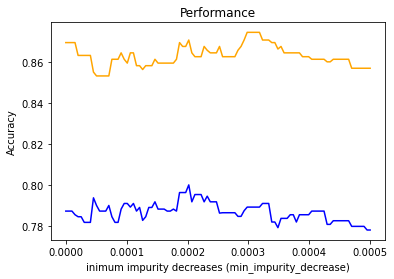

In [30]:
min_impurity_decreases = np.linspace(0, 0.0005, num=100)

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for min_impurity_decrease in min_impurity_decreases:

    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=40,
                                max_depth=9,
                                max_features=5,
                                min_samples_split=10,
                                criterion="gini", 
                                min_impurity_decrease=min_impurity_decrease,
                                random_state=2,
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

table = pd.DataFrame(np.column_stack([min_impurity_decreases, test_accuracies, train_accuracies]), 
                    columns=['Minimum Impurity Decrease', 'Test', 'Train'])
print(table.loc[table['Test'] == max(test_accuracies)])

# Plot results
plt.xlabel('inimum impurity decreases (min_impurity_decrease)')
plt.ylabel('Accuracy')
plt.title("Performance")
plt.plot(min_impurity_decreases, test_accuracies, color="blue")
plt.plot(min_impurity_decreases, train_accuracies, color="orange")
plt.show()


The optimal minimum impurity decrease is 0.000202 because the test accuracy is the highest here.

### Finalizing the model

In [31]:
# Prepare the model 
rf = RandomForestClassifier(n_estimators=40,
                            max_depth=9,
                            max_features=5,
                            min_samples_split=10,
                            criterion="gini", 
                            min_impurity_decrease=0.000202,
                            random_state=2,
                            verbose=False)


train_accuracy, test_accuracy = fit_test_model(rf)

# Train and test result
print(train_accuracy, test_accuracy)


0.8706460674157304 0.8000545553737043


## Predicting Survival Values

In [44]:
f = prepare_data(pd.read_csv('test.csv'))

# Fill null values
f["Fare"].fillna(f["Fare"].mean(), inplace=True)

# Only use target features
x_pred = f.loc[:, ~f.columns.isin(['Name', 'Ticket', 'PassengerId'])]

# Export Kaggle Competition Submission
df = pd.read_csv('test.csv')
df['Survived'] = rf.predict(x_pred)
final = df.loc[:, df.columns.isin(['PassengerId', 'Survived'])]

final.to_csv('submission.csv', index=False)